# **Final Project Notebook**
## *Electricity Production and Consumption Dataset*

In [2]:
#Imports

# Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller


# Train/Test Splitting
from sklearn.model_selection import train_test_split

# Models
import tensorflow as tf
import statsmodels.api as sm
from tcn import TCN, tcn_full_summary
from tensorflow.keras.models import Sequential
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense,TimeDistributed, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Visulaizations
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [1]:
!pip install keras-tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.2 MB/s eta 0:00:00


#### 1) Reading the Dataset

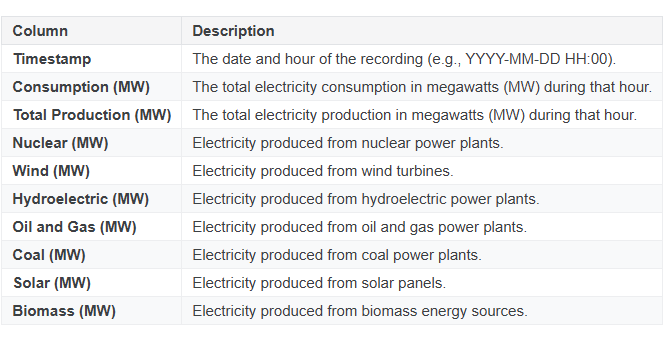

In [5]:
df=pd.read_csv('electricity.csv',parse_dates = ['DateTime'],index_col='DateTime')
df.head()

,Consumption,Production,Nuclear,Wind,Oil and Gas,Coal
DateTime,,,,,,
2019-01-01 00:00:00,6352,6527,1395,79,1896,1744
2019-01-01 01:00:00,6116,5701,1393,96,1429,1641
2019-01-01 02:00:00,5873,5676,1393,142,1465,1616
2019-01-01 03:00:00,5682,5603,1397,191,1455,1558
2019-01-01 04:00:00,5557,5454,1393,159,1454,1458


#### 2) Explore the Dataset

- Explore the Electricity trends over time

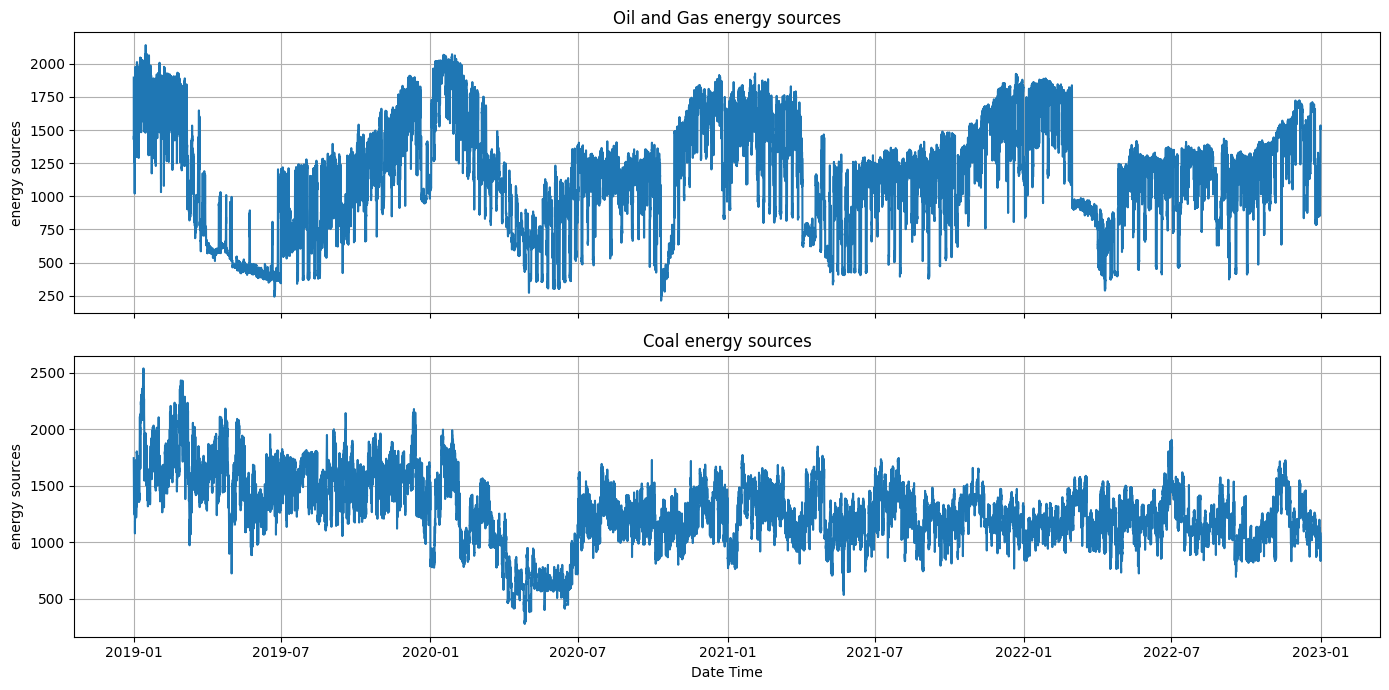

In [7]:
# Define the energy sources of interest
energy_sources = ['Oil and Gas', 'Coal']

# Create subplots for the selected energy sources
fig, axes = plt.subplots(nrows=len(energy_sources), ncols=1, figsize=(14, 7), sharex=True)

# Plot each energy source in its own subplot
for i, source in enumerate(energy_sources):
    axes[i].plot(df.index, df[source], label=source)
    axes[i].set_ylabel('energy sources')
    axes[i].set_title(f'{source} energy sources')
    axes[i].grid(True)

# Set common x-axis label and adjust layout
plt.xlabel('Date Time')
plt.tight_layout()
plt.show()

- The Distribution of Electricity Generation by Source

 *Comparing the distributions of electricity generation from different sources (nuclear, wind, hydroelectric) using histograms*




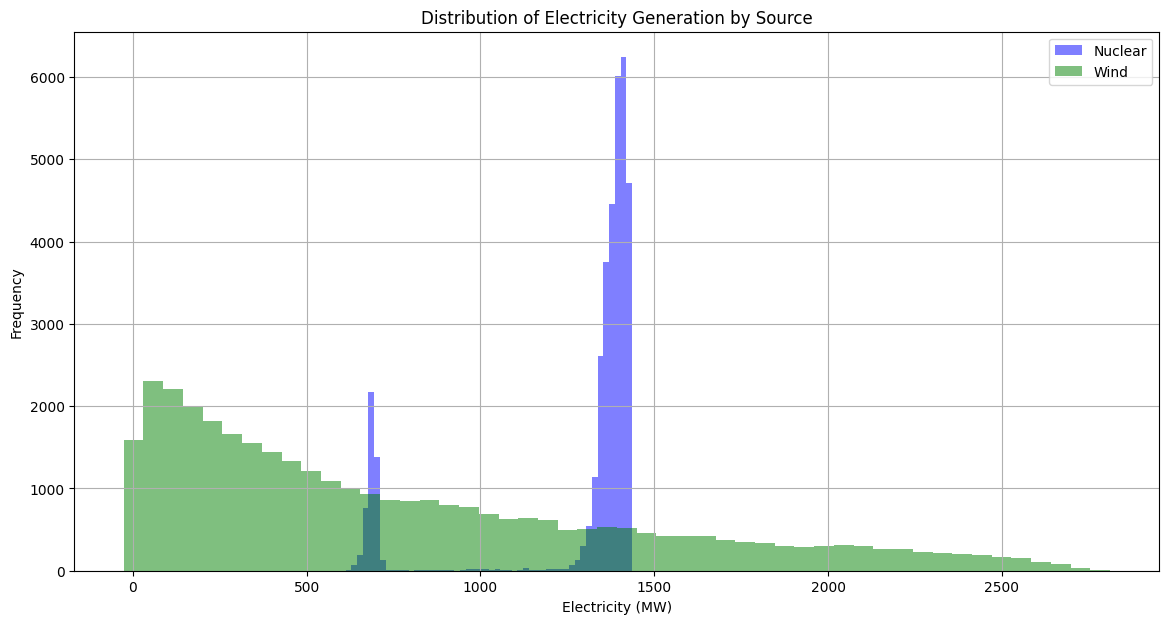

In [8]:
plt.figure(figsize=(14, 7))

plt.hist(df['Nuclear'], bins=50, alpha=0.5, label='Nuclear', color='blue')
plt.hist(df['Wind'], bins=50, alpha=0.5, label='Wind', color='green')

plt.xlabel('Electricity (MW)')
plt.ylabel('Frequency')
plt.title('Distribution of Electricity Generation by Source')
plt.legend()
plt.grid(True)
plt.show()


1.   The Histogram shows that the Frequency of production of Nuclear,wind and Hydroelectric.

2.  By this plot it is shown that Nuclear production is Higher than wind and Hydroelectric.

- Lineplot of Hourly Electricity Consumption and Production.

*Comparing the trends of hourly electricity consumption and production over a period of time according to this dataset.*

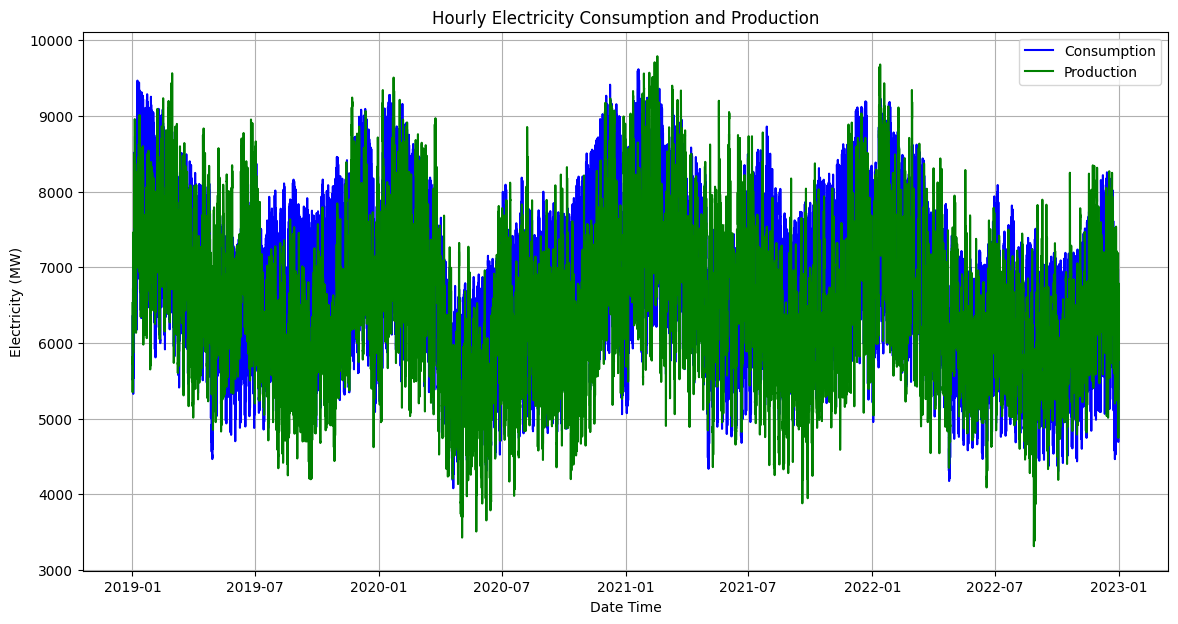

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Consumption'], label='Consumption', color='blue')
plt.plot(df.index, df['Production'], label='Production', color='green')

plt.xlabel('Date Time')
plt.ylabel('Electricity (MW)')
plt.title('Hourly Electricity Consumption and Production')
plt.legend()
plt.grid(True)
plt.show()

- Proportion of Total Electricity Production

*Visualizing the proportion of total electricity production of different energy sources using a pie chart.*

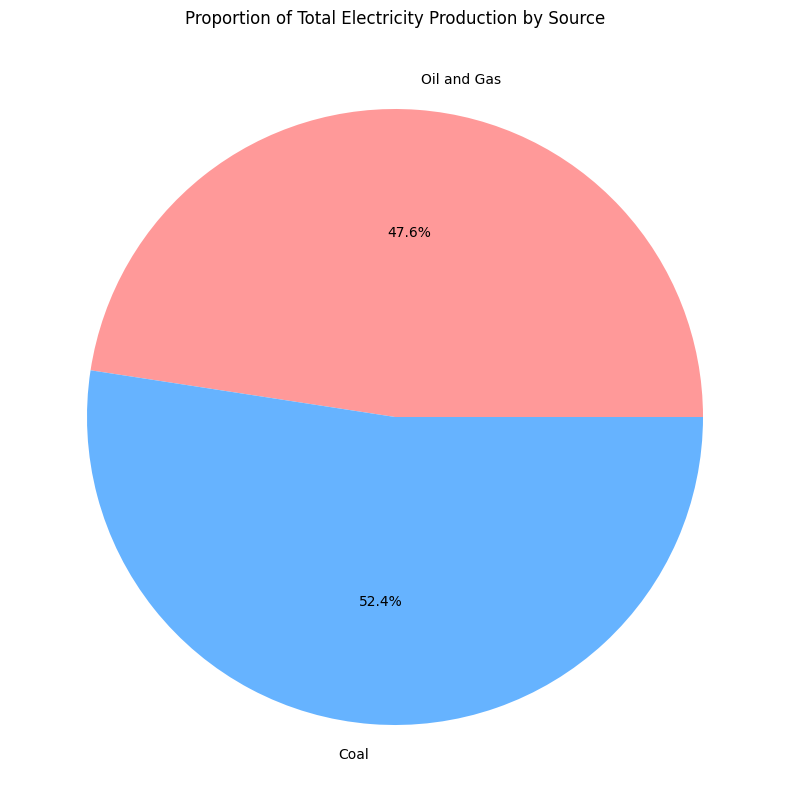

In [10]:
total_production_by_source = df[energy_sources].sum()

plt.figure(figsize=(10, 10))
total_production_by_source.plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6','#c4e17f'])

plt.ylabel('')
plt.title('Proportion of Total Electricity Production by Source')
plt.show()

- Correlation Matrix of Electricity Production and Consumption Dataset

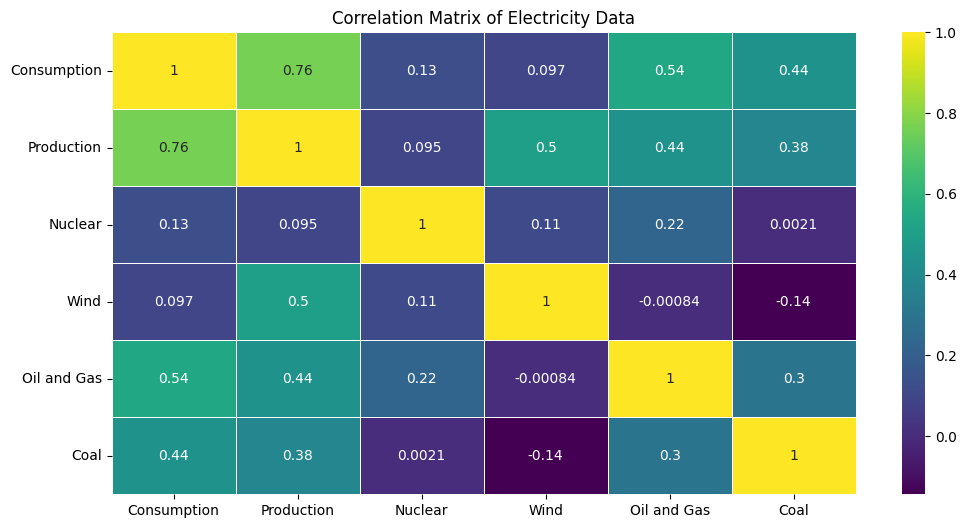

In [11]:
plt.figure(figsize=(12, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='viridis', linewidths=0.5)

plt.title('Correlation Matrix of Electricity Data')
plt.show()

#### 3) Preprocessing

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35068 entries, 2019-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Consumption  35068 non-null  int64
 1   Production   35068 non-null  int64
 2   Nuclear      35068 non-null  int64
 3   Wind         35068 non-null  int64
 4   Oil and Gas  35068 non-null  int64
 5   Coal         35068 non-null  int64
dtypes: int64(6)
memory usage: 1.9 MB


In [13]:
df.describe()

,Consumption,Production,Nuclear,Wind,Oil and Gas,Coal
count,35068.000000,35068.000000,35068.000000,35068.000000,35068.000000,35068.000000
mean,6715.948757,6505.219146,1288.707939,768.959707,1164.469973,1283.104397
std,1039.101116,992.406639,241.996312,670.333887,420.541886,307.434482
min,4081.000000,3315.000000,612.000000,-26.000000,213.000000,279.000000
25%,5908.000000,5801.000000,1347.000000,220.000000,864.000000,1104.000000
50%,6692.000000,6452.000000,1385.000000,563.000000,1204.000000,1272.000000
75%,7439.000000,7165.000000,1410.000000,1171.000000,1460.000000,1477.000000
max,9615.000000,9787.000000,1436.000000,2811.000000,2141.000000,2537.000000


- Checking for null data

In [14]:
df.isnull().sum()

Consumption    0
Production     0
Nuclear        0
Wind           0
Oil and Gas    0
Coal           0
dtype: int64

- Normalize the data

In [16]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[['Consumption', 'Production', 'Nuclear', 'Wind', 'Oil and Gas', 'Coal']])

# Convert to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=['Consumption', 'Production', 'Nuclear', 'Wind', 'Oil and Gas', 'Coal'])
scaled_df.head()

,Consumption,Production,Nuclear,Wind,Oil and Gas,Coal
0,0.410372,0.496292,0.950243,0.037011,0.872925,0.648804
1,0.367727,0.368665,0.947816,0.043003,0.630705,0.603189
2,0.323816,0.364802,0.947816,0.059217,0.649378,0.592117
3,0.289302,0.353523,0.952670,0.076489,0.644191,0.566430
4,0.266715,0.330501,0.947816,0.065210,0.643672,0.522143


#### 4) Models

 - Check for Stationarity
     - Augmented Dickey-Fuller

In [17]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [18]:
for name, column in scaled_df.items():
    Augmented_Dickey_Fuller_Test_func(column,name)
    print('\n')

Results of Dickey-Fuller Test for column: Consumption
Test Statistic                -1.404965e+01
p-value                        3.194378e-26
No Lags Used                   5.100000e+01
Number of Observations Used    3.501600e+04
Critical Value (1%)           -3.430537e+00
Critical Value (5%)           -2.861623e+00
Critical Value (10%)          -2.566814e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Production
Test Statistic                -1.415940e+01
p-value                        2.093833e-26
No Lags Used                   5.100000e+01
Number of Observations Used    3.501600e+04
Critical Value (1%)           -3.430537e+00
Critical Value (5%)           -2.861623e+00
Critical Value (10%)          -2.566814e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Nuclear
Test Statistic                -6.902265e+00
p-value                

*Since Data is staionary. There is no need for differencing.*



# **Multivariate Timeseries**



# **STATISTICAL MODELS**



In [19]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
train=train.astype(np.float64)
test=test.astype(np.float64)
train.shape,test.shape

((28054, 6), (7014, 6))

In [20]:
def calculate_metrics(true_values, predictions, model_name):
    r2 = r2_score(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    print(f'{model_name} - R² Score: {r2}')
    print(f'{model_name} - Mean Absolute Error (MAE): {mae}')
    print(f'{model_name} - Mean Squared Error (MSE): {mse}')
    print(f'{model_name} - Root Mean Squared Error (RMSE): {rmse}')

- VARMAX

In [21]:
varmax_model = VARMAX(train, order=(1, 2),trends = 't').fit( disp=False)
varmax_model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['trends']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizati

Dep. Variable:,"['Consumption', 'Production', 'Nuclear', 'Wind', 'Oil and Gas', 'Coal']",No. Observations:,28054
Model:,"VARMA(1,2)",Log Likelihood,-974789.099
,+ intercept,AIC,1949848.198
Date:,"Sun, 07 Jul 2024",BIC,1950960.852
Time:,22:22:16,HQIC,1950206.349
Sample:,0,,
,- 28054,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"285.76, 11.11, 0.00, 0.04, 0.54, 5.65",Jarque-Bera (JB):,"839.79, 5198.17, 132309360.64, 52792.23, 62532.53, 18171.69"
Prob(Q):,"0.00, 0.00, 0.98, 0.84, 0.46, 0.02",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"0.99, 1.20, 1.74, 0.95, 0.94, 0.52",Skew:,"0.16, -0.02, -9.20, 0.21, -0.43, -0.02"


In [22]:
# Make predictions
varmax_forecast = varmax_model.get_forecast(steps=len(test))
varmax_predictions = varmax_forecast.predicted_mean

# Metrics for VARMAX
calculate_metrics(test, varmax_predictions, 'VARMAX')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


VARMAX - R² Score: -0.24366498765242559
VARMAX - Mean Absolute Error (MAE): 456.42742129403814
VARMAX - Mean Squared Error (MSE): 435804.90301774704
VARMAX - Root Mean Squared Error (RMSE): 660.1552113084824


In [51]:
VARMAX_R2 = -0.24366498765242559
VARMAX_MAE= 456.42742129403814
VARMAX_MSE = 435804.90301774704
VARMAX_RMSE = 660.1552113084824

- SARIMAX

In [24]:
SARIMAX_model = sm.tsa.SARIMAX(endog=train['Consumption'], exog=train[['Production', 'Nuclear', 'Wind', 'Oil and Gas', 'Coal']], order=(1, 0, 2), seasonal_order=(2, 1, 2, 12))
results =SARIMAX_model.fit()
results.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Consumption   No. Observations:                28054
Model:             SARIMAX(1, 0, 2)x(2, 1, 2, 12)   Log Likelihood             -168576.146
Date:                            Sun, 07 Jul 2024   AIC                         337178.293
Time:                                    22:45:47   BIC                         337285.432
Sample:                                         0   HQIC                        337212.780
                                          - 28054                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Production      0.3952      0.004    109.646      0.000       0.388       0.402
Nuclear        -0.1942      0.035     -5.504      0.000      -0.263      -0.125
Wind           -0.1004      0.005    -21.434      0.000      -0.110      -0.091
Oil and Gas    -0.1008      0.008    -12.437      0.000      -0.117      -0.085
Coal           -0.0358      0.011     -3.389      0.001      -0.056      -0.015
ar.L1           0.9988      0.000   2665.596      0.000       0.998       1.000
ma.L1           0.2328      0.004     56.287      0.000       0.225       0.241
ma.L2           0.1423      0.005     27.030      0.000       0.132       0.153
ar.S.L12       -1.0211      0.007   -140.291      0.000      -1.035      -1.007
ar.S.L24       -0.0211      0.007     -2.905      0.004      -0.035      -0.007
ma.S.L12        0.0291      0.004      8.048      0.000       0.022       0.036
ma.S.L24       -0.8427      0.003   -330.431      0.000      -0.848      -0.838
sigma2       1.025e+04     60.698    168.901      0.000    1.01e+04    1.04e+04
===================================================================================
Ljung-Box (L1) (Q):                  19.67   Jarque-Bera (JB):             14007.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
forecast = results.forecast(steps=len(test),exog=test[['Production', 'Nuclear', 'Wind', 'Oil and Gas', 'Coal']])
# Metrics for SARIMAX
calculate_metrics(test['Consumption'],forecast  , 'SARIMAX')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


SARIMAX - R² Score: -15.356796967131782
SARIMAX - Mean Absolute Error (MAE): 3395.13531336427
SARIMAX - Mean Squared Error (MSE): 12191072.856976276
SARIMAX - Root Mean Squared Error (RMSE): 3491.57168864915


In [52]:
SARIMAX_R2 = -15.356796967131782
SARIMAX_MAE= 3395.13531336427
SARIMAX_MSE = 12191072.856976276
SARIMAX_RMSE = 3491.57168864915

# **DEEP LEARNING MODELS**

- Create sequences

In [26]:
# Create sequences
def create_sequences(df, seq_length):
    sequences = []
    labels = []
    for i in range(len(df) - seq_length):
        seq = df.iloc[i:i+seq_length].values
        label = df['Consumption'].iloc[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 24  # for 24 hours sequence
sequences, labels = create_sequences(scaled_df, SEQ_LENGTH)

- Train/Test Split

In [27]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

- RNN Model

In [28]:
# RNN Model
rnn_model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    SimpleRNN(50),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Simple RNN Model Training
rnn_history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
701/701 [==============================] - 14s 16ms/step - loss: 0.0194 - val_loss: 0.0022
Epoch 2/20
701/701 [==============================] - 16s 23ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 3/20
701/701 [==============================] - 11s 15ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 4/20
701/701 [==============================] - 11s 15ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/20
701/701 [==============================] - 11s 16ms/step - loss: 0.0012 - val_loss: 8.5686e-04
Epoch 6/20
701/701 [==============================] - 9s 13ms/step - loss: 0.0010 - val_loss: 8.5039e-04
Epoch 7/20
701/701 [==============================] - 11s 15ms/step - loss: 9.5620e-04 - val_loss: 8.1522e-04
Epoch 8/20
701/701 [==============================] - 11s 15ms/step - loss: 9.5852e-04 - val_loss: 8.0884e-04
Epoch 9/20
701/701 [==============================] - 11s 15ms/step - loss: 9.1239e-04 - val_loss: 0.0017
Epoch 10/20
701/701 [==============================] - 

- RNN Model Evaluation

In [29]:
rnn_predictions = rnn_model.predict(X_test)

# Calculate evaluation metrics for Simple RNN
rnn_r2 = r2_score(y_test, rnn_predictions)
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_rmse = np.sqrt(rnn_mse)

print(f'Simple RNN - R² Score: {rnn_r2}')
print(f'Simple RNN - Mean Absolute Error (MAE): {rnn_mae}')
print(f'Simple RNN - Mean Squared Error (MSE): {rnn_mse}')
print(f'Simple RNN - Root Mean Squared Error (RMSE): {rnn_rmse}')

220/220 [==============================] - 1s 5ms/step
Simple RNN - R² Score: 0.975094629615661
Simple RNN - Mean Absolute Error (MAE): 0.018017288988637362
Simple RNN - Mean Squared Error (MSE): 0.0006051687141201447
Simple RNN - Root Mean Squared Error (RMSE): 0.024600177115625503


- Actual Vs Predicted Consumption

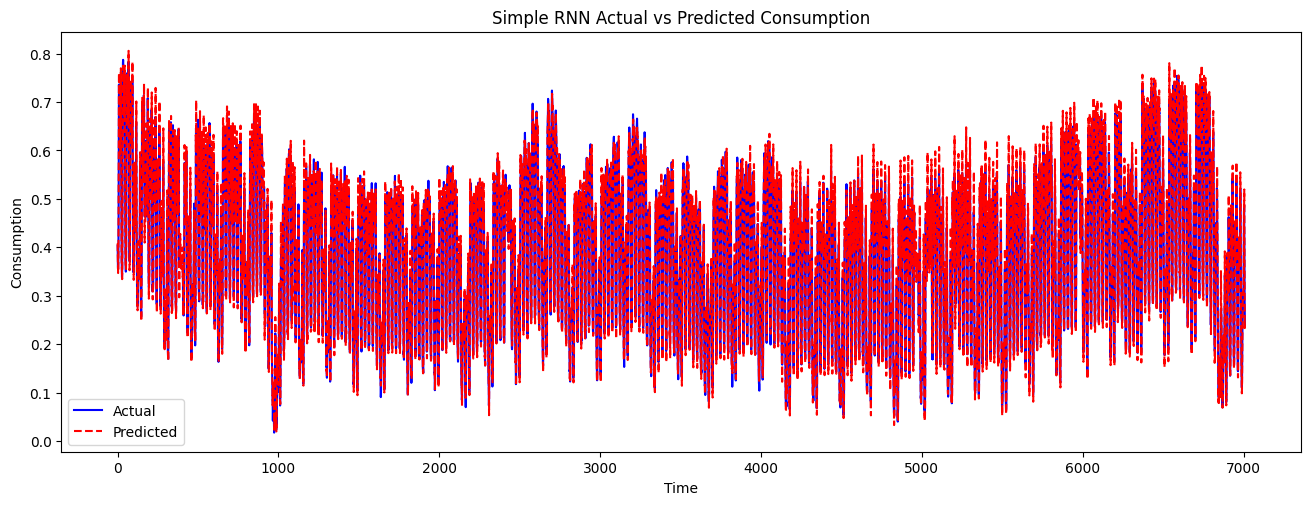

In [30]:
plt.figure(figsize=(16, 12))
# Simple RNN
plt.subplot(2, 1, 1)
plt.plot(y_test, label='Actual', color='blue')
plt.plot(rnn_predictions, label='Predicted', color='red', linestyle='dashed')
plt.title('Simple RNN Actual vs Predicted Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()

- LSTM Model

In [31]:
# LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# LSTM Model Training
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
701/701 [==============================] - 25s 30ms/step - loss: 0.0106 - val_loss: 0.0021
Epoch 2/20
701/701 [==============================] - 19s 27ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3/20
701/701 [==============================] - 20s 28ms/step - loss: 0.0011 - val_loss: 9.9200e-04
Epoch 4/20
701/701 [==============================] - 19s 28ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 5/20
701/701 [==============================] - 19s 27ms/step - loss: 0.0010 - val_loss: 9.2369e-04
Epoch 6/20
701/701 [==============================] - 21s 30ms/step - loss: 9.5939e-04 - val_loss: 8.7762e-04
Epoch 7/20
701/701 [==============================] - 19s 27ms/step - loss: 8.7555e-04 - val_loss: 8.4241e-04
Epoch 8/20
701/701 [==============================] - 19s 27ms/step - loss: 7.8565e-04 - val_loss: 6.8313e-04
Epoch 9/20
701/701 [==============================] - 20s 29ms/step - loss: 7.0567e-04 - val_loss: 5.7397e-04
Epoch 10/20
701/701 [=====================

- LSTM Model Evaluation

In [32]:
lstm_predictions = lstm_model.predict(X_test)

# Calculate evaluation metrics for LSTM
lstm_r2 = r2_score(y_test, lstm_predictions)
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)

print(f'LSTM - R² Score: {lstm_r2}')
print(f'LSTM - Mean Absolute Error (MAE): {lstm_mae}')
print(f'LSTM - Mean Squared Error (MSE): {lstm_mse}')
print(f'LSTM - Root Mean Squared Error (RMSE): {lstm_rmse}')

220/220 [==============================] - 3s 8ms/step
LSTM - R² Score: 0.9808148007407181
LSTM - Mean Absolute Error (MAE): 0.015961717198914413
LSTM - Mean Squared Error (MSE): 0.0004661758563196936
LSTM - Root Mean Squared Error (RMSE): 0.021591105954065753


- Actual Vs Predicted Consumption

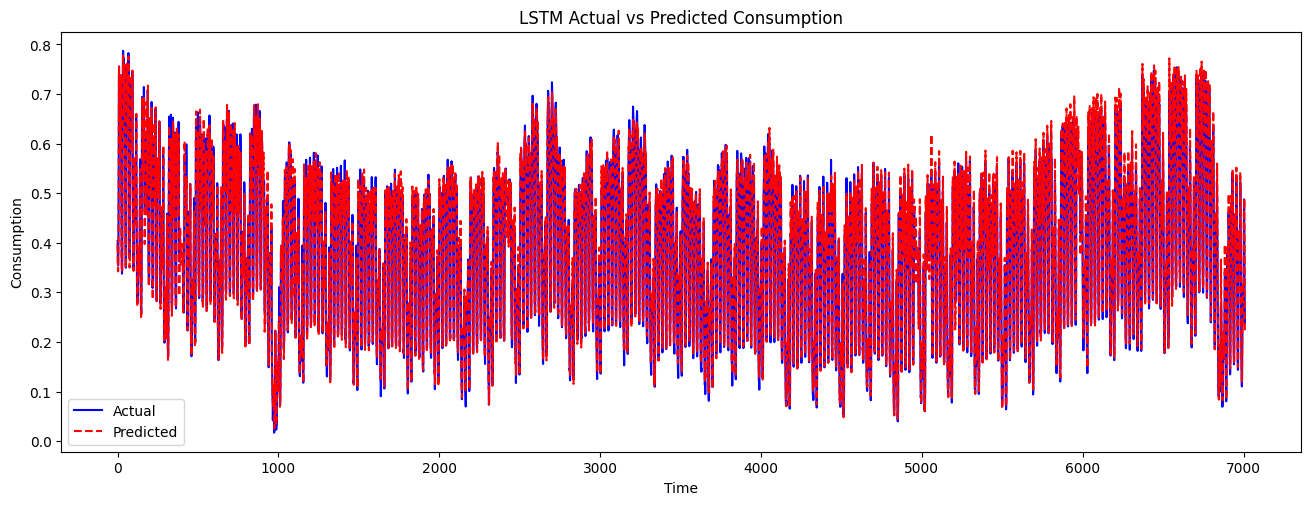

In [33]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 1)
plt.plot(y_test, label='Actual', color='blue')
plt.plot(lstm_predictions, label='Predicted', color='red', linestyle='dashed')
plt.title('LSTM Actual vs Predicted Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()

- TCN Model

In [34]:
tcn_model = Sequential([
    TCN(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    TCN(50),
    Dense(1)
])

# Compile the Model
tcn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the TCN Model
tcn_history = tcn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
701/701 [==============================] - 65s 83ms/step - loss: 4.0374 - val_loss: 0.0473
Epoch 2/20
701/701 [==============================] - 58s 82ms/step - loss: 0.0288 - val_loss: 0.0217
Epoch 3/20
701/701 [==============================] - 56s 81ms/step - loss: 0.0209 - val_loss: 0.0181
Epoch 4/20
701/701 [==============================] - 56s 81ms/step - loss: 0.0174 - val_loss: 0.0346
Epoch 5/20
701/701 [==============================] - 59s 85ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 6/20
701/701 [==============================] - 59s 84ms/step - loss: 0.0134 - val_loss: 0.0139
Epoch 7/20
701/701 [==============================] - 56s 81ms/step - loss: 0.0108 - val_loss: 0.0203
Epoch 8/20
701/701 [==============================] - 59s 84ms/step - loss: 0.0076 - val_loss: 0.0048
Epoch 9/20
701/701 [==============================] - 59s 84ms/step - loss: 0.0080 - val_loss: 0.0152
Epoch 10/20
701/701 [==============================] - 58s 83ms/step - loss: 0.005

- TCN Model Evaluation

In [35]:
# Make predictions with the TCN model
tcn_predictions = tcn_model.predict(X_test)

# Calculate evaluation metrics for TCN
tcn_r2 = r2_score(y_test, tcn_predictions)
tcn_mae = mean_absolute_error(y_test, tcn_predictions)
tcn_mse = mean_squared_error(y_test, tcn_predictions)
tcn_rmse = np.sqrt(tcn_mse)

print(f'TCN - R² Score: {tcn_r2}')
print(f'TCN - Mean Absolute Error (MAE): {tcn_mae}')
print(f'TCN - Mean Squared Error (MSE): {tcn_mse}')
print(f'TCN - Root Mean Squared Error (RMSE): {tcn_rmse}')

220/220 [==============================] - 6s 26ms/step
TCN - R² Score: 0.9557969997567128
TCN - Mean Absolute Error (MAE): 0.025059272396860476
TCN - Mean Squared Error (MSE): 0.0010740764905188343
TCN - Root Mean Squared Error (RMSE): 0.03277310620796928


- Actual Vs Predicted Consumption

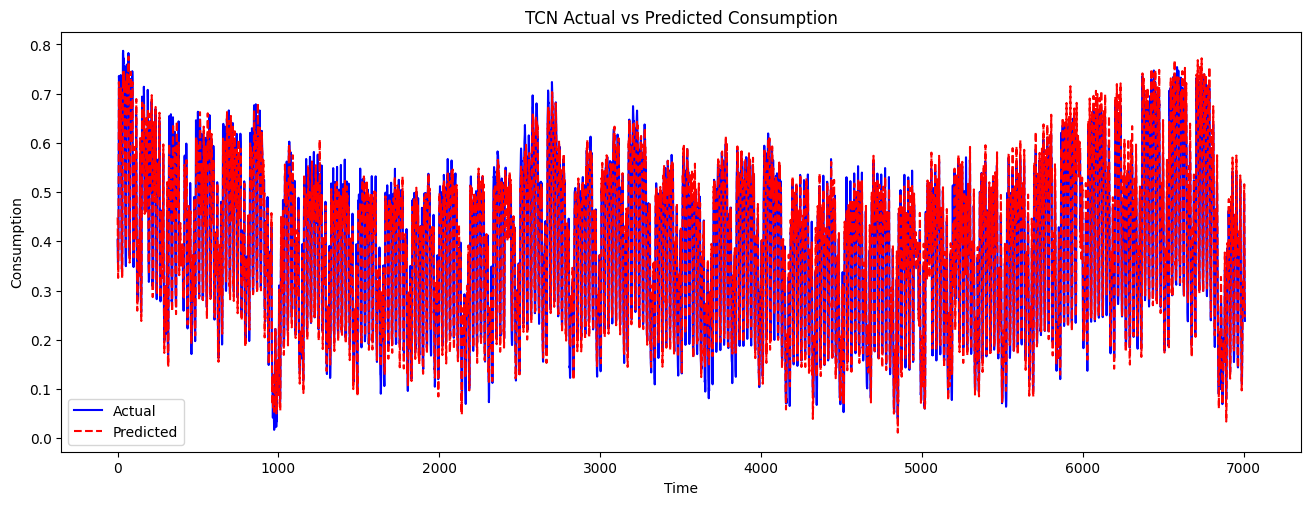

In [36]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 1)
plt.plot(y_test, label='Actual', color='blue')
plt.plot(tcn_predictions, label='Predicted', color='red', linestyle='dashed')
plt.title('TCN Actual vs Predicted Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()

#### 5) Comparison Table

In [54]:
rnn_metrics = {
    "Model": "Simple RNN",
    "R2 Score": rnn_r2,
    "MAE": rnn_mae,
    "MSE": rnn_mse,
    "RMSE": rnn_rmse
}

lstm_metrics = {
    "Model": "LSTM",
    "R2 Score": lstm_r2,
    "MAE": lstm_mae,
    "MSE": lstm_mse,
    "RMSE": lstm_rmse
}

tcn_metrics = {
    "Model": "TCN",
    "R2 Score": tcn_r2,
    "MAE": tcn_mae,
    "MSE": tcn_mse,
    "RMSE": tcn_rmse

}

VARMAX_metrics={
    "Model": "VARMAX",
    "R2 Score": VARMAX_R2,
    "MAE": VARMAX_MAE,
    "MSE": VARMAX_MSE,
    "RMSE": VARMAX_RMSE
}

SARIMAX_metrics={
    "Model": "SARIMAX",
    "R2 Score": SARIMAX_R2,
    "MAE": SARIMAX_MAE,
    "MSE": SARIMAX_MSE,
    "RMSE": SARIMAX_RMSE
}

comparison_df = pd.DataFrame([rnn_metrics, lstm_metrics, tcn_metrics,VARMAX_metrics,SARIMAX_metrics])
comparison_df.head()


,Model,R2 Score,MAE,MSE,RMSE
0,Simple RNN,0.975095,0.018017,6.051687e-04,0.024600
1,LSTM,0.980815,0.015962,4.661759e-04,0.021591
2,TCN,0.955797,0.025059,1.074076e-03,0.032773
3,VARMAX,-0.243665,456.427421,4.358049e+05,660.155211
4,SARIMAX,-15.356797,3395.135313,1.219107e+07,3491.571689


In [56]:
# Function to highlight the best result per column
def highlight_best(s):
    is_best = s == s.min() if s.name in ["MAE", "MSE", "RMSE"] else s == s.max()
    return ['background-color: yellow' if v else '' for v in is_best]

# Apply the highlighting function
comparison_df.style.apply(highlight_best, subset=["R2 Score", "MAE", "MSE", "RMSE"])

,Model,R2 Score,MAE,MSE,RMSE
0,Simple RNN,0.975095,0.018017,0.000605,0.024600
1,LSTM,0.980815,0.015962,0.000466,0.021591
2,TCN,0.955797,0.025059,0.001074,0.032773
3,VARMAX,-0.243665,456.427421,435804.903018,660.155211
4,SARIMAX,-15.356797,3395.135313,12191072.856976,3491.571689
